## <font color=FF4455>Classification for OSA</font>


# Data Preparation

### Dependencies

In [64]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
import numpy as np
import os

We'll first start by splitting the data into train and test sets

In [45]:
def split_data(xlsx_data):
    """
    Reads xlsx file, separates features from variables, and split it into train and test
    """
    df = pd.read_excel(xlsx_data)
    # Define feature matrix (X) and target variable (y)
    if 'Patient' in df.columns:
        df = df.drop('Patient', axis=1)
    
    # Add OSA category based on IAH values: 0: No OSA, 1: OSA
    df.loc[:, 'OSA'] = df['IAH'].apply(lambda x: 0 if x <= 10 else (1 if x >= 30 else None))

    # Remove rows with IAH values larger than 10 and less than 30
    df = df.dropna(subset=['OSA'])
    
    X = df.drop(['IAH', 'OSA'], axis=1)  # Features
    y = df['OSA']  # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [46]:
X_train, X_test, y_train, y_test = split_data("../datasets/Clinical_data.xlsx")
X_train_norm, X_test_norm, y_train_norm, y_test_norm = split_data("../datasets/Clinical_data_norm.xlsx")
X_train_selec, X_test_selec, y_train_selec, y_test_selec = split_data("../datasets/Clinical_selected_features.xlsx")

In [47]:
print(f"Training set size: {len(X_train)}")
# print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 335
Test set size: 84


# Models

We will try to fit a model for the 3 datasets we have: The original, the normalized, and the one with only selected features according to Pearson correlation.

### Useful functions

In [48]:
def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Fits a classification model and returns evaluation metrics.
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        "train_accuracy": accuracy_score(y_train, y_train_pred),
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "test_precision": precision_score(y_test, y_test_pred, average='weighted'),
        "test_recall": recall_score(y_test, y_test_pred, average='weighted'),
        "test_f1_score": f1_score(y_test, y_test_pred, average='weighted')
    }

    # Get predicted probabilities for ROC
    y_test_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_probs)
    roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve
    
    return metrics, roc_auc, fpr, tpr

In [49]:
def plot_multiple_roc(roc_aucs, fprs, tprs, labels=["original", "normalized", "selected"]):
    """
    Plots multiple ROC curves on the same graph.
    """
    plt.figure(figsize=(10, 6))
    
    for i in range(len(roc_aucs)):
        plt.plot(fprs[i], tprs[i], label=f'{labels[i]} (AUC = {roc_aucs[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [73]:
def plot_losses(all_losses, loss_type):
    """
    Plots the MSE or MAE losses for all models across different datasets.
    """
    # Initialize plot data
    models = list(all_losses.keys())  # List of model names
    datasets = ["Original", "Normalized", "Selected"]  # Dataset types
    
    # Prepare the plot
    plt.figure(figsize=(10, 6))
    
    # Iterate over dataset types
    for i, dataset in enumerate(datasets):
        losses = []
        for model in models:
            losses.append(all_losses[model][dataset][loss_type])
        
        # Plot each dataset's losses for the selected loss_type (MSE or MAE)
        x_pos = np.arange(len(models))
        plt.bar(x_pos + (i * 0.25), losses, width=0.25, label=f'{dataset} {loss_type}')
    
    # Add labels and title
    plt.xticks(x_pos + 0.25, models, rotation=45)
    plt.ylabel(f'{loss_type} Loss')
    plt.title(f'{loss_type} Losses for Each Model and Dataset Type')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


### Logistic Regression

In [51]:
# Initialize the model
logistic_model = LogisticRegression(max_iter=1000)

# Initialize lists of ROC to plot them 
roc_aucs, fprs, tprs = [None]*3, [None]*3, [None]*3

# Fit and evaluate the model on the original dataset
logistic_metrics_original, roc_aucs[0], fprs[0], tprs[0] = fit_and_evaluate_model(logistic_model, X_train, y_train, X_test, y_test)
print(f"Logistic Regression - Original dataset metrics: {logistic_metrics_original}")

# Fit and evaluate the model on the normalized dataset
logistic_metrics_norm, roc_aucs[1], fprs[1], tprs[1] = fit_and_evaluate_model(logistic_model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
print(f"Logistic Regression - Normalized dataset metrics: {logistic_metrics_norm}")

# Fit and evaluate the model on the selected features dataset
logistic_metrics_selec, roc_aucs[2], fprs[2], tprs[2] = fit_and_evaluate_model(logistic_model, X_train_selec, y_train_selec, X_test_selec, y_test_selec)
print(f"Logistic Regression - Selected features dataset metrics: {logistic_metrics_selec}")

Logistic Regression - Original dataset metrics: {'train_accuracy': 0.7402985074626866, 'test_accuracy': 0.7023809523809523, 'test_precision': 0.7016369047619047, 'test_recall': 0.7023809523809523, 'test_f1_score': 0.7019088817935248}
Logistic Regression - Normalized dataset metrics: {'train_accuracy': 0.7432835820895523, 'test_accuracy': 0.7261904761904762, 'test_precision': 0.7249719887955183, 'test_recall': 0.7261904761904762, 'test_f1_score': 0.7246399358349409}
Logistic Regression - Selected features dataset metrics: {'train_accuracy': 0.7343283582089553, 'test_accuracy': 0.7142857142857143, 'test_precision': 0.7129275952805364, 'test_recall': 0.7142857142857143, 'test_f1_score': 0.7119533527696792}


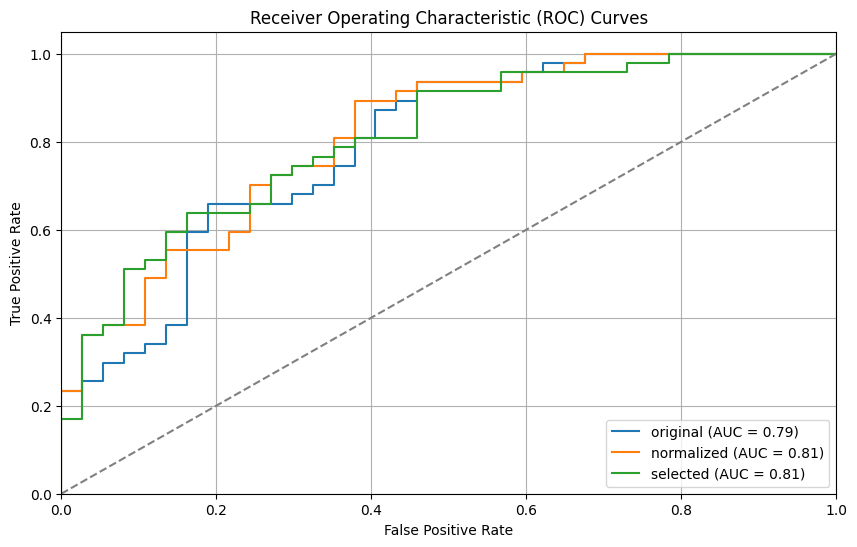

In [43]:
plot_multiple_roc(roc_aucs, fprs, tprs)

Let's store the losse inside a dictionary so that we can use them later

In [44]:
# Store the losses in a dictionary
LogReg_loss = {
    'Original': logistic_metrics_original,
    'Normalized': logistic_metrics_norm,
    'Selected': logistic_metrics_selec
}

### SVM

In [53]:
# Initialize the SVM model
svm_model = SVC(probability=True)

# Initialize lists of ROC to plot them 
svm_roc_aucs, svm_fprs, svm_tprs = [None]*3, [None]*3, [None]*3

# Fit and evaluate the model on the original dataset
svm_metrics_original, svm_roc_aucs[0], svm_fprs[0], svm_tprs[0] = fit_and_evaluate_model(svm_model, X_train, y_train, X_test, y_test)
print(f"SVM - Original dataset metrics: {svm_metrics_original}")

# Fit and evaluate the model on the normalized dataset
svm_metrics_norm, svm_roc_aucs[1], svm_fprs[1], svm_tprs[1] = fit_and_evaluate_model(svm_model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
print(f"SVM - Normalized dataset metrics: {svm_metrics_norm}")

# Fit and evaluate the model on the selected features dataset
svm_metrics_selec, svm_roc_aucs[2], svm_fprs[2], svm_tprs[2] = fit_and_evaluate_model(svm_model, X_train_selec, y_train_selec, X_test_selec, y_test_selec)
print(f"SVM - Selected features dataset metrics: {svm_metrics_selec}")

SVM - Original dataset metrics: {'train_accuracy': 0.7194029850746269, 'test_accuracy': 0.7023809523809523, 'test_precision': 0.7042942176870748, 'test_recall': 0.7023809523809523, 'test_f1_score': 0.6947793307016609}
SVM - Normalized dataset metrics: {'train_accuracy': 0.746268656716418, 'test_accuracy': 0.7142857142857143, 'test_precision': 0.7164021164021164, 'test_recall': 0.7142857142857143, 'test_f1_score': 0.7149395227198431}
SVM - Selected features dataset metrics: {'train_accuracy': 0.6985074626865672, 'test_accuracy': 0.7023809523809523, 'test_precision': 0.7126984126984127, 'test_recall': 0.7023809523809523, 'test_f1_score': 0.6887471090780422}


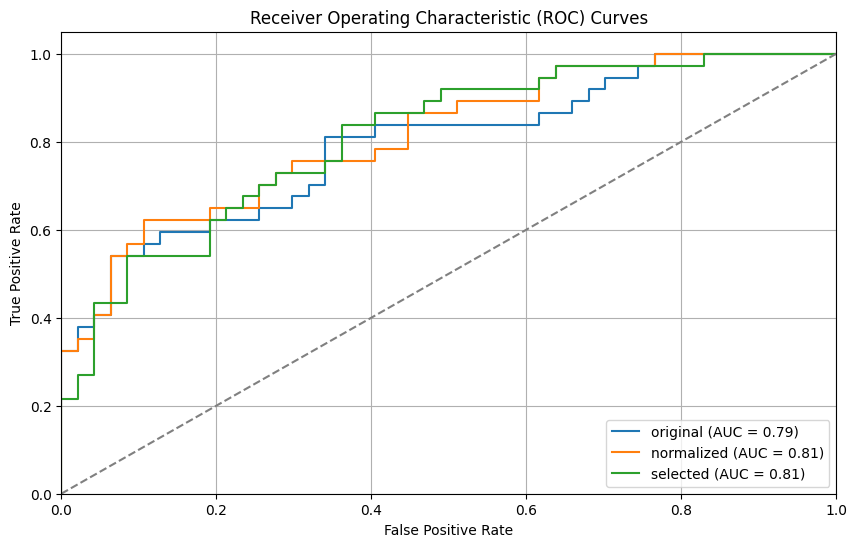

In [54]:
plot_multiple_roc(roc_aucs, fprs, tprs)

In [55]:
SVM_losses = {
    'Original': svm_metrics_original,
    'Normalized': svm_metrics_norm,
    'Selected': svm_metrics_selec
}

### KNN

In [57]:
# Initialize the KNN model
knn_model = KNeighborsClassifier()

# Initialize lists of ROC to plot them 
knn_roc_aucs, knn_fprs, knn_tprs = [None]*3, [None]*3, [None]*3

# Fit and evaluate the model on the original dataset
knn_metrics_original, knn_roc_aucs[0], knn_fprs[0], knn_tprs[0] = fit_and_evaluate_model(knn_model, X_train, y_train, X_test, y_test)
print(f"KNN - Original dataset metrics: {knn_metrics_original}")

# Fit and evaluate the model on the normalized dataset
knn_metrics_norm, knn_roc_aucs[1], knn_fprs[1], knn_tprs[1] = fit_and_evaluate_model(knn_model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
print(f"KNN - Normalized dataset metrics: {knn_metrics_norm}")

# Fit and evaluate the model on the selected features dataset
knn_metrics_selec, knn_roc_aucs[2], knn_fprs[2], knn_tprs[2] = fit_and_evaluate_model(knn_model, X_train_selec, y_train_selec, X_test_selec, y_test_selec)
print(f"KNN - Selected features dataset metrics: {knn_metrics_selec}")

KNN - Original dataset metrics: {'train_accuracy': 0.8208955223880597, 'test_accuracy': 0.6666666666666666, 'test_precision': 0.685834770941154, 'test_recall': 0.6666666666666666, 'test_f1_score': 0.6666666666666666}
KNN - Normalized dataset metrics: {'train_accuracy': 0.835820895522388, 'test_accuracy': 0.6785714285714286, 'test_precision': 0.689935064935065, 'test_recall': 0.6785714285714286, 'test_f1_score': 0.6795292829775589}
KNN - Selected features dataset metrics: {'train_accuracy': 0.8059701492537313, 'test_accuracy': 0.6547619047619048, 'test_precision': 0.658495670995671, 'test_recall': 0.6547619047619048, 'test_f1_score': 0.6557965843680129}


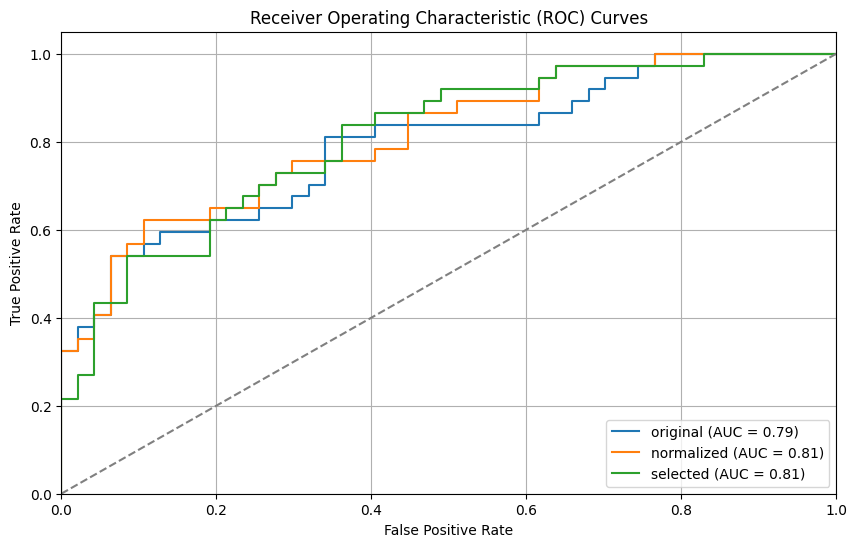

In [58]:
plot_multiple_roc(roc_aucs, fprs, tprs)

In [59]:
KNN_losses = {
    'Original': knn_metrics_original,
    'Normalized': knn_metrics_norm,
    'Selected': knn_metrics_selec
}


### Random forest

In [61]:

# Initialize the Random Forest model
rf_model = RandomForestClassifier()

# Initialize lists of ROC to plot them 
rf_roc_aucs, rf_fprs, rf_tprs = [None]*3, [None]*3, [None]*3

# Fit and evaluate the model on the original dataset
rf_metrics_original, rf_roc_aucs[0], rf_fprs[0], rf_tprs[0] = fit_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test)
print(f"Random Forest - Original dataset metrics: {rf_metrics_original}")

# Fit and evaluate the model on the normalized dataset
rf_metrics_norm, rf_roc_aucs[1], rf_fprs[1], rf_tprs[1] = fit_and_evaluate_model(rf_model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
print(f"Random Forest - Normalized dataset metrics: {rf_metrics_norm}")

# Fit and evaluate the model on the selected features dataset
rf_metrics_selec, rf_roc_aucs[2], rf_fprs[2], rf_tprs[2] = fit_and_evaluate_model(rf_model, X_train_selec, y_train_selec, X_test_selec, y_test_selec)
print(f"Random Forest - Selected features dataset metrics: {rf_metrics_selec}")

Random Forest - Original dataset metrics: {'train_accuracy': 1.0, 'test_accuracy': 0.6904761904761905, 'test_precision': 0.6957161764308673, 'test_recall': 0.6904761904761905, 'test_f1_score': 0.6915343915343916}
Random Forest - Normalized dataset metrics: {'train_accuracy': 1.0, 'test_accuracy': 0.6785714285714286, 'test_precision': 0.689935064935065, 'test_recall': 0.6785714285714286, 'test_f1_score': 0.6795292829775589}
Random Forest - Selected features dataset metrics: {'train_accuracy': 0.9940298507462687, 'test_accuracy': 0.7142857142857143, 'test_precision': 0.7235232152985982, 'test_recall': 0.7142857142857143, 'test_f1_score': 0.7152597402597403}


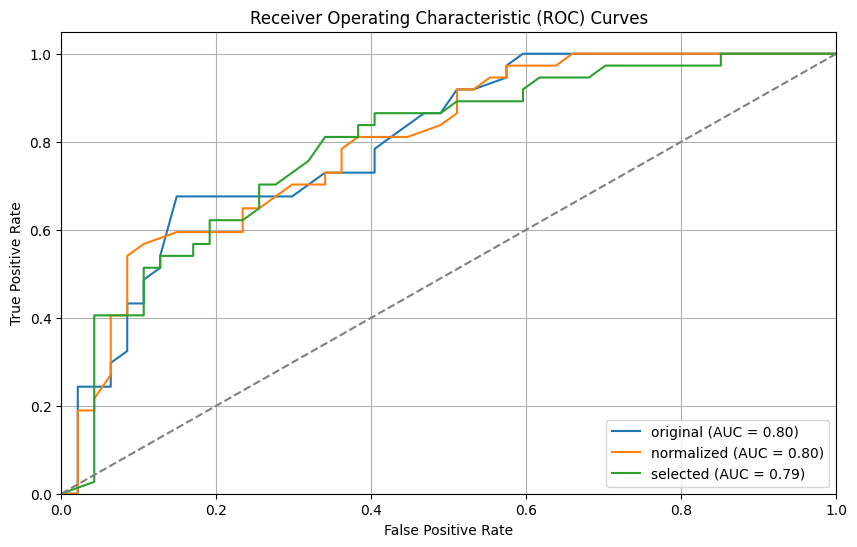

In [62]:
plot_multiple_roc(rf_roc_aucs, rf_fprs, rf_tprs, labels=["original", "normalized", "selected"])

In [63]:
RF_losses = {
    'Original': rf_metrics_original,
    'Normalized': rf_metrics_norm,
    'Selected': rf_metrics_selec
}

### Decision tree

In [65]:

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier()

# Initialize lists of ROC to plot them 
dt_roc_aucs, dt_fprs, dt_tprs = [None]*3, [None]*3, [None]*3

# Fit and evaluate the model on the original dataset
dt_metrics_original, dt_roc_aucs[0], dt_fprs[0], dt_tprs[0] = fit_and_evaluate_model(dt_model, X_train, y_train, X_test, y_test)
print(f"Decision Tree - Original dataset metrics: {dt_metrics_original}")

# Fit and evaluate the model on the normalized dataset
dt_metrics_norm, dt_roc_aucs[1], dt_fprs[1], dt_tprs[1] = fit_and_evaluate_model(dt_model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
print(f"Decision Tree - Normalized dataset metrics: {dt_metrics_norm}")

# Fit and evaluate the model on the selected features dataset
dt_metrics_selec, dt_roc_aucs[2], dt_fprs[2], dt_tprs[2] = fit_and_evaluate_model(dt_model, X_train_selec, y_train_selec, X_test_selec, y_test_selec)
print(f"Decision Tree - Selected features dataset metrics: {dt_metrics_selec}")

Decision Tree - Original dataset metrics: {'train_accuracy': 1.0, 'test_accuracy': 0.6547619047619048, 'test_precision': 0.6659361471861471, 'test_recall': 0.6547619047619048, 'test_f1_score': 0.6557907113462669}
Decision Tree - Normalized dataset metrics: {'train_accuracy': 1.0, 'test_accuracy': 0.7142857142857143, 'test_precision': 0.7286121286121285, 'test_recall': 0.7142857142857143, 'test_f1_score': 0.714933959970829}
Decision Tree - Selected features dataset metrics: {'train_accuracy': 0.9940298507462687, 'test_accuracy': 0.6666666666666666, 'test_precision': 0.6666666666666666, 'test_recall': 0.6666666666666666, 'test_f1_score': 0.6666666666666666}


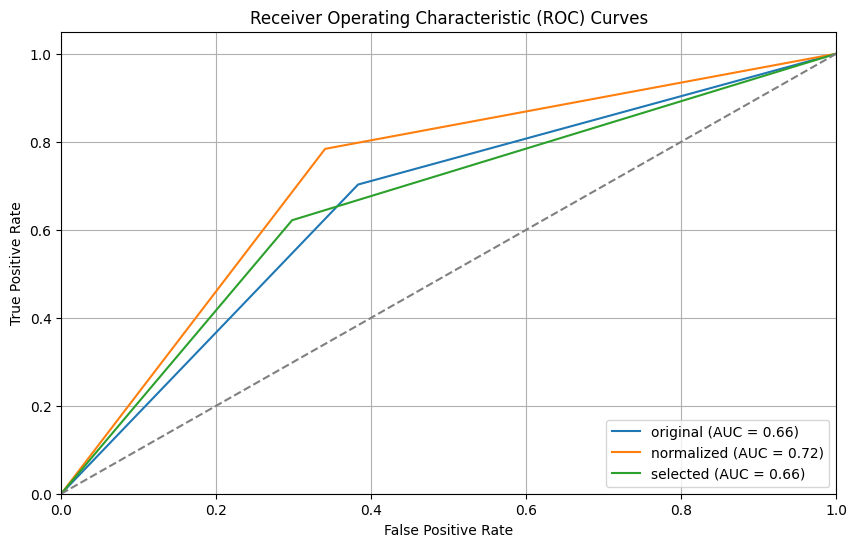

In [66]:
plot_multiple_roc(dt_roc_aucs, dt_fprs, dt_tprs, labels=["original", "normalized", "selected"])

In [67]:
DT_losses = {
    'Original': dt_metrics_original,
    'Normalized': dt_metrics_norm,
    'Selected': dt_metrics_selec
}

In [69]:
all_losses = {
    'Logistic Regression': LogReg_loss,
    'SVM': SVM_losses,
    'KNN': KNN_losses,
    'Random Forest': RF_losses,
    'Decision Tree': DT_losses
}

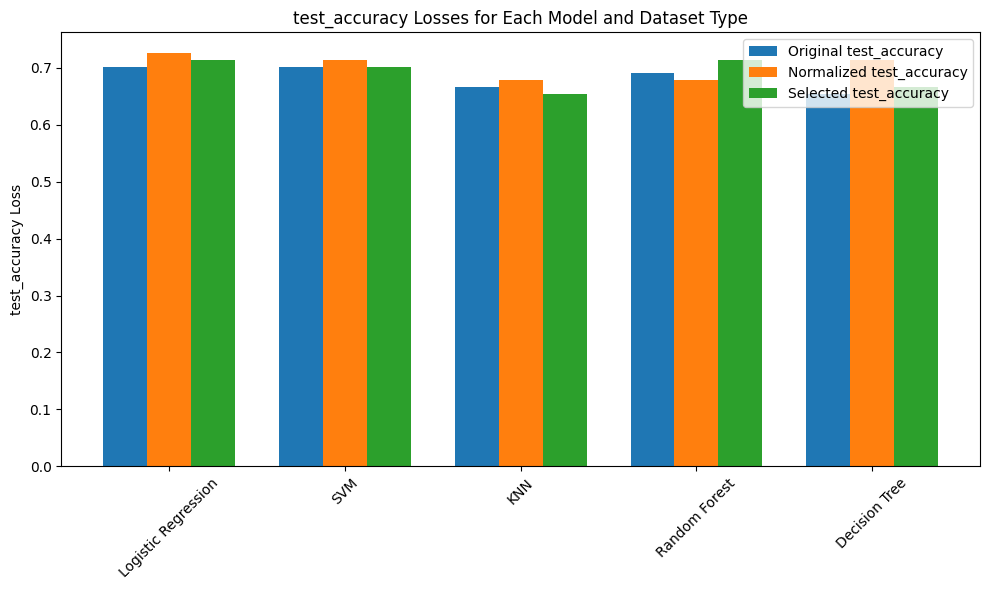

In [74]:
plot_losses(all_losses, 'test_accuracy')

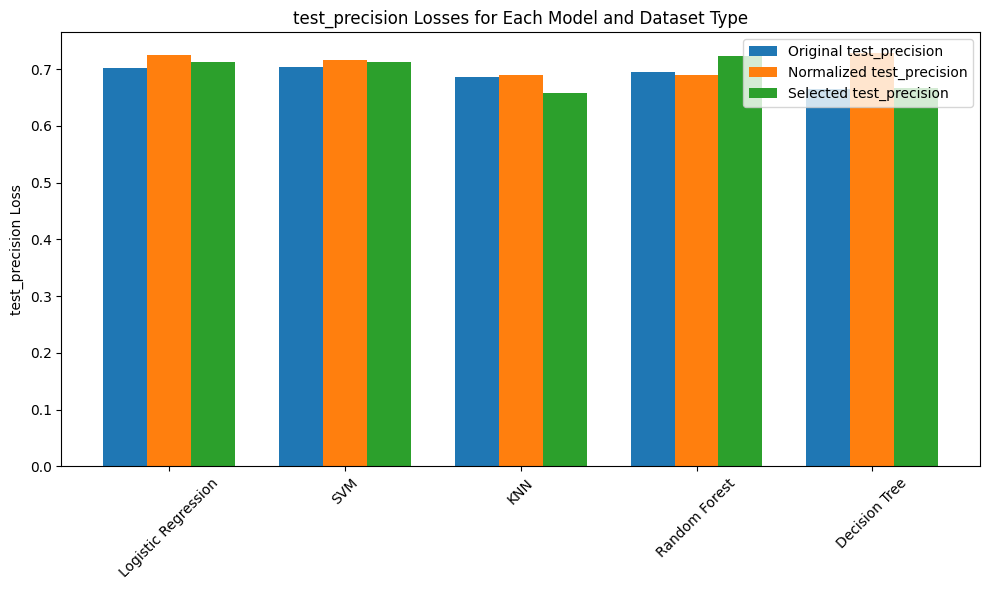

In [75]:
plot_losses(all_losses, 'test_precision')

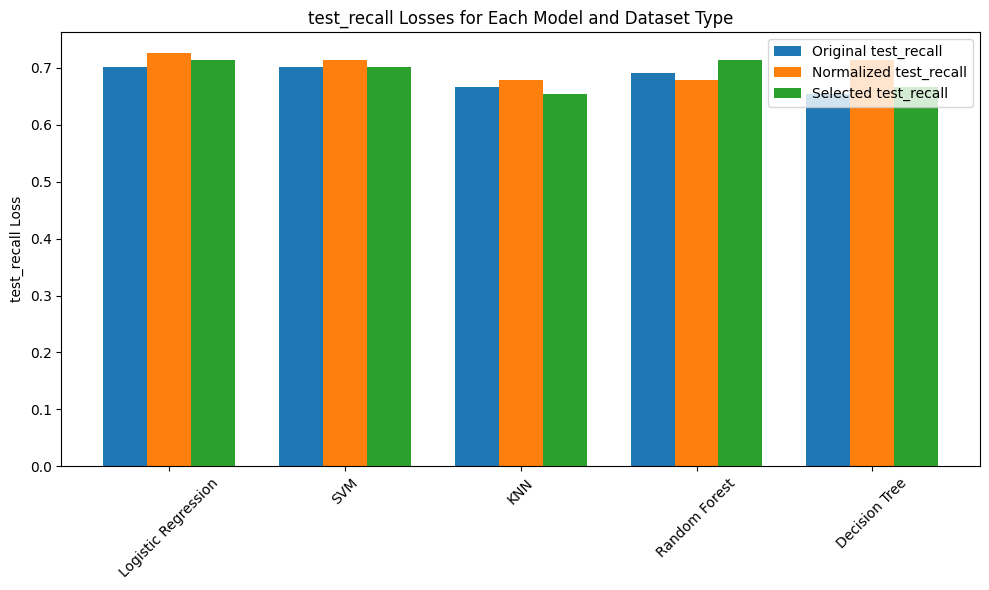

In [76]:
plot_losses(all_losses, 'test_recall')

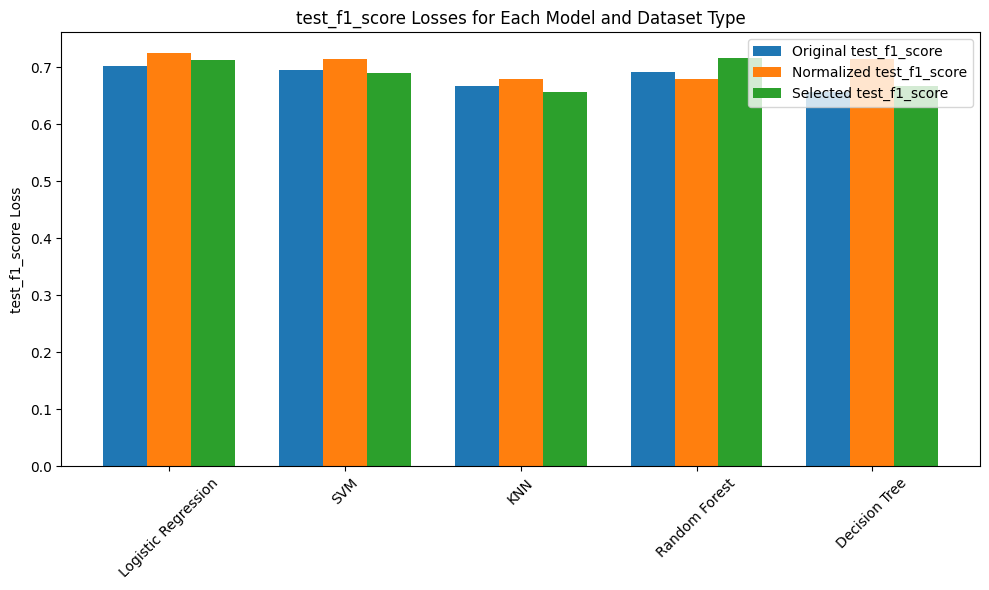

In [78]:
plot_losses(all_losses, 'test_f1_score')

# Classification per gender

Comparison between the performance of a model trained on the whole dataset, and models trained on a specific gender. The comparison should be done on the same test set for all models.

### Useful functions

In [82]:
def fit_and_evaluate_model_gender(model, X_train, y_train, X_test_m, X_test_f, y_test_m, y_test_f):
    """
    Fits a classification model and returns evaluation metrics for each gender
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_test_pred = model.predict(X_test)
    y_test_pred_m = model.predict(X_test_m)
    y_test_pred_f = model.predict(X_test_f)

    # Calculate metrics
    all_dataset_metrics = {
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "test_precision": precision_score(y_test, y_test_pred, average='weighted'),
        "test_recall": recall_score(y_test, y_test_pred, average='weighted'),
        "test_f1_score": f1_score(y_test, y_test_pred, average='weighted')
    }

    male_metrics = {
        "test_accuracy": accuracy_score(y_test_m, y_test_pred_m),
        "test_precision": precision_score(y_test_m, y_test_pred_m, average='weighted'),
        "test_recall": recall_score(y_test_m, y_test_pred_m, average='weighted'),
        "test_f1_score": f1_score(y_test_m, y_test_pred_m, average='weighted')
    }

    female_metrics = {
        "test_accuracy": accuracy_score(y_test_f, y_test_pred_f),
        "test_precision": precision_score(y_test_f, y_test_pred_f, average='weighted'),
        "test_recall": recall_score(y_test_f, y_test_pred_f, average='weighted'),
        "test_f1_score": f1_score(y_test_f, y_test_pred_f, average='weighted')
    }
    
    
    return all_dataset_metrics, male_metrics, female_metrics

In [115]:
def plot_gender_comparison(metric, all_dataset_metrics, male_metrics, female_metrics, male_dataset_metrics, female_dataset_metrics):
    """
    Plots the comparison of a specific metric for the whole dataset model and gender-specific models.
    """
    # Extract metric values
    whole_value_male = male_metrics[metric]
    whole_value_female = female_metrics[metric]
    male_value = male_dataset_metrics[metric]
    female_value = female_dataset_metrics[metric]
    

    # Set up the bar data
    labels = ['Male', 'Female']
    general_values = [all_dataset_metrics[metric], all_dataset_metrics[metric]]
    whole_values = [whole_value_male, whole_value_female]
    gender_specific_values = [male_value, female_value]
    
    # Bar positions
    x = np.arange(len(labels))
    width = 0.25  # Width of the bars

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the bars
    ax.bar(x - width, general_values, width, label='General Model Evaluated on the Whole Dataset', color='lightgreen')
    ax.bar(x, whole_values, width, label='General Model Evaluated on Specific Gender Subset', color='skyblue')
    ax.bar(x + width, gender_specific_values, width, label='Gender Specific Model', color='lightcoral')

    # Add labels and formatting
    ax.set_xlabel('Gender')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'Comparison of {metric.replace("_", " ").title()} by Gender')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

In [85]:
# Split the training data into male and female subsets
X_train_m = X_train[X_train['Gender'] == 1].drop('Gender', axis=1)
y_train_m = y_train[X_train['Gender'] == 1]

X_train_f = X_train[X_train['Gender'] == 0].drop('Gender', axis=1)
y_train_f = y_train[X_train['Gender'] == 0]

# Split the test data into male and female subsets
X_test_m = X_test[X_test['Gender'] == 1]
y_test_m = y_test[X_test['Gender'] == 1]

X_test_f = X_test[X_test['Gender'] == 0]
y_test_f = y_test[X_test['Gender'] == 0]

### The whole dataset:

In [86]:
model = LogisticRegression(max_iter=1000)

# Fit and evaluate the model on the original dataset
all_dataset_metrics, male_metrics, female_metrics = fit_and_evaluate_model_gender(model, X_train, y_train, X_test_m, X_test_f, y_test_m, y_test_f)

In [88]:
print(f"Evaluated on the whole dataset: {all_dataset_metrics}")
print(f"Evaluated on male subset: {male_metrics}")
print(f"Evaluated on female subset: {female_metrics}")

Evaluated on the whole dataset: {'test_accuracy': 0.7023809523809523, 'test_precision': 0.7016369047619047, 'test_recall': 0.7023809523809523, 'test_f1_score': 0.7019088817935248}
Evaluated on male subset: {'test_accuracy': 0.7166666666666667, 'test_precision': 0.7162738496071829, 'test_recall': 0.7166666666666667, 'test_f1_score': 0.7162703962703962}
Evaluated on female subset: {'test_accuracy': 0.6666666666666666, 'test_precision': 0.6031746031746031, 'test_recall': 0.6666666666666666, 'test_f1_score': 0.6333333333333334}


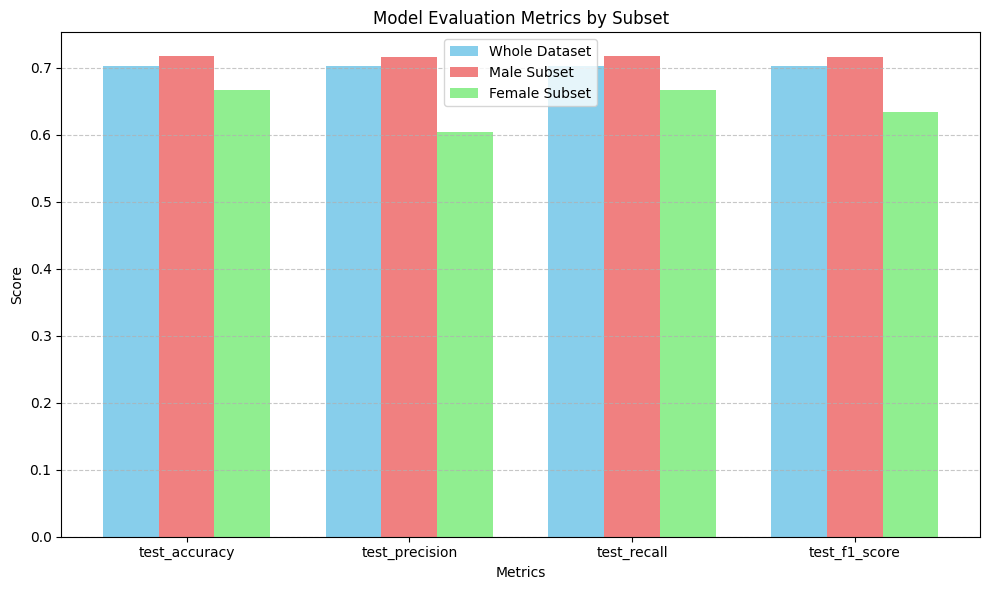

In [89]:
# Extract metric names and values for each dataset
labels = list(all_dataset_metrics.keys())
whole_values = list(all_dataset_metrics.values())
male_values = list(male_metrics.values())
female_values = list(female_metrics.values())

# Set up plot details
x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data for each group
ax.bar(x - width, whole_values, width, label='Whole Dataset', color='skyblue')
ax.bar(x, male_values, width, label='Male Subset', color='lightcoral')
ax.bar(x + width, female_values, width, label='Female Subset', color='lightgreen')

# Add labels and formatting
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics by Subset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

### Now we want to train a seperate model for male and for female patients and see how they compare to the modle trained on the whole dataset

In [97]:
X_test_m = X_test_m.drop('Gender', axis=1)
X_test_f = X_test_f.drop('Gender', axis=1)

### Male patients

In [98]:
# Initialize the model
male_model = LogisticRegression(max_iter=1000)

# Fit and evaluate the model on the male dataset
male_dataset_metrics, _, _, _ = fit_and_evaluate_model(male_model, X_train_m, y_train_m, X_test_m, y_test_m)

print(male_dataset_metrics)

{'train_accuracy': 0.7288888888888889, 'test_accuracy': 0.7, 'test_precision': 0.700925925925926, 'test_recall': 0.7, 'test_f1_score': 0.6972850678733031}


### Female Patients

In [99]:
# Initialize the model
female_model = LogisticRegression(max_iter=1000)

# Fit and evaluate the model on the male dataset
female_dataset_metrics, _, _, _ = fit_and_evaluate_model(female_model, X_train_f, y_train_f, X_test_f, y_test_f)

print(female_dataset_metrics)

{'train_accuracy': 0.7727272727272727, 'test_accuracy': 0.625, 'test_precision': 0.650462962962963, 'test_recall': 0.625, 'test_f1_score': 0.6369778869778869}


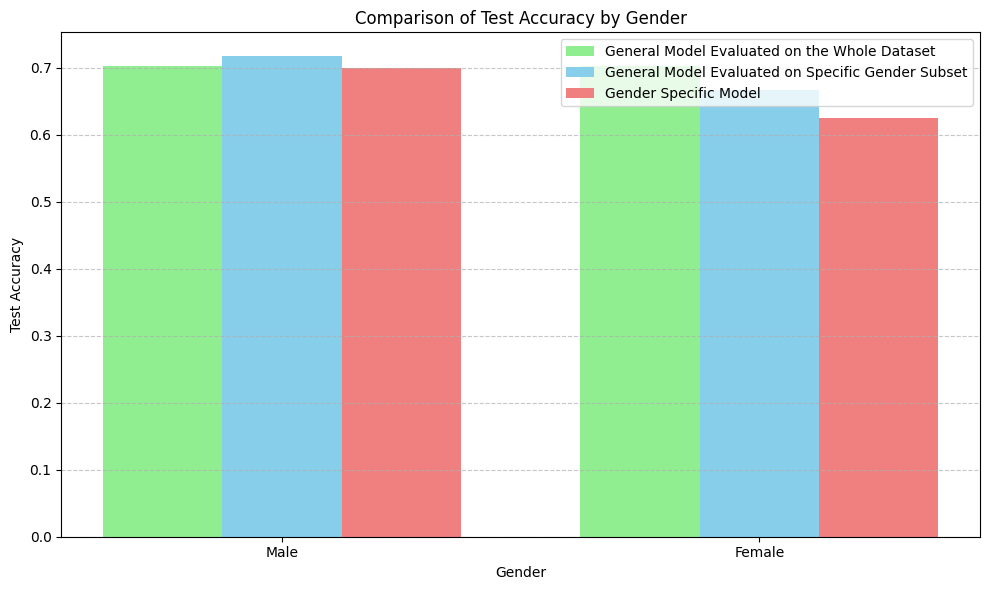

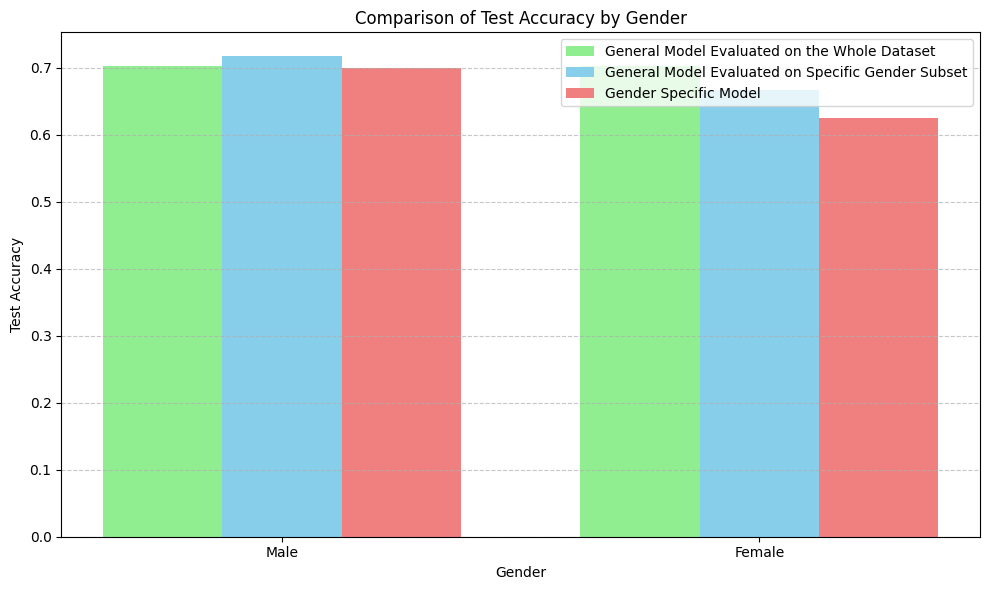

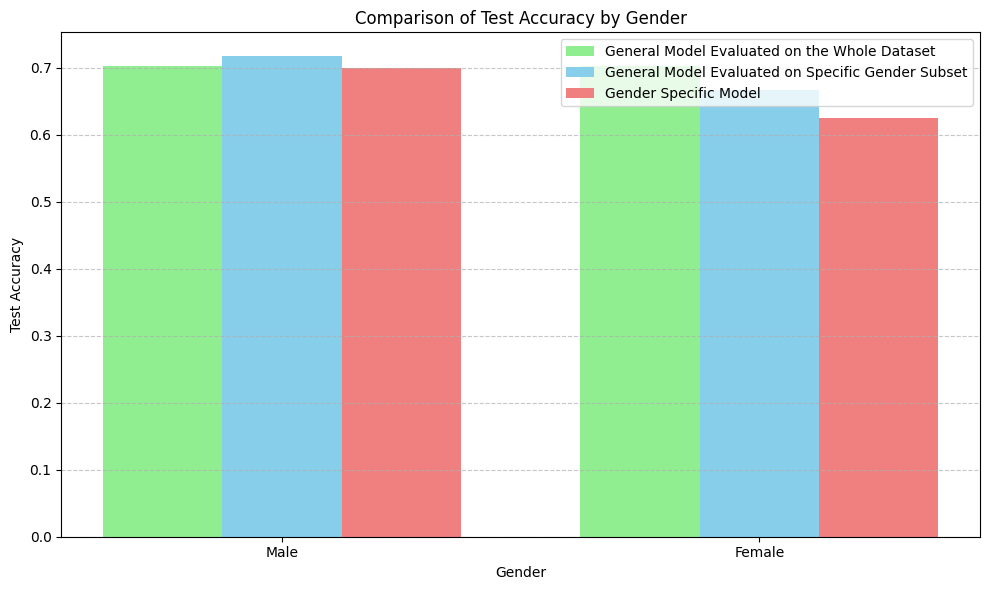

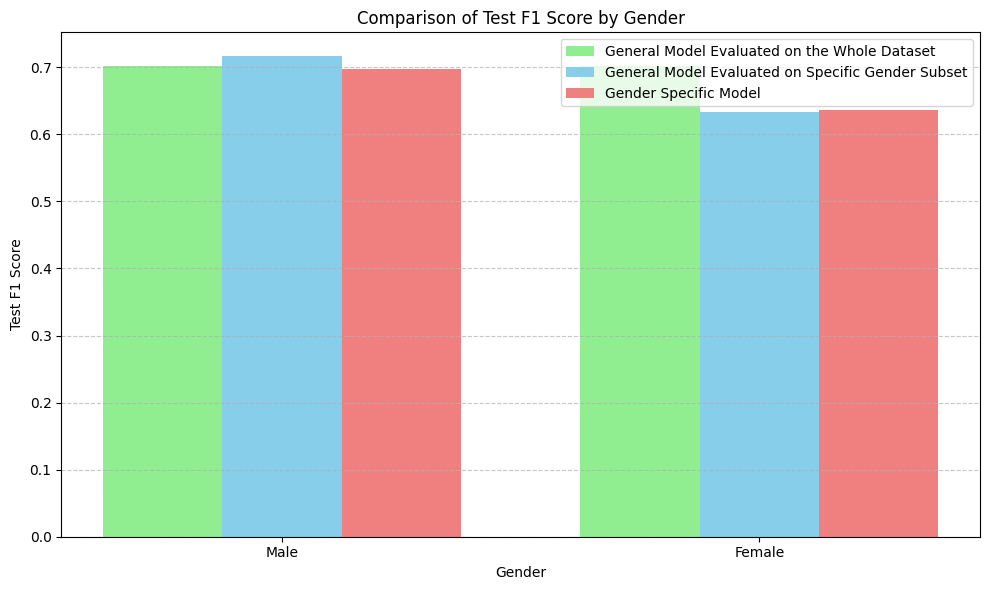

In [116]:
for metric in ['test_accuracy', 'test_accuracy', 'test_accuracy', 'test_f1_score']:
    plot_gender_comparison(metric, all_dataset_metrics, male_metrics, female_metrics, male_dataset_metrics, female_dataset_metrics)